# Reduce on Plateau Learning Rate Scheduler

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/main/examples/contrib/reduce_on_plateau.ipynb)

In this notebook, we explore the power of {py:func}`optax.contrib.reduce_on_plateau` scheduler, that reduces the learning rate when a metric has stopped improving. We will be solving a classification task by training a simple Multilayer Perceptron (MLP) on the fashion MNIST dataset.

In [2]:
from typing import Sequence
from flax import linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import optax
from optax import tree_utils as otu
from optax import contrib

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on TPU


## Data and model setup

Fashion MNIST is a dataset of 28x28 grayscale image, associated with a label from 10 classes. We now load the dataset using `tensorflow_datasets`, apply min-max normalization to the images, shuffle the data in the train set and create batches of size `BATCH_SIZE`.


In [3]:
# @markdown Number of samples in each batch:
BATCH_SIZE = 128  # @param{type:"integer"}

In [4]:
(train_loader, test_loader), info = tfds.load(
    "fashion_mnist", split=["train", "test"], as_supervised=True, with_info=True
)

min_max_norm = lambda image, label: (tf.cast(image, tf.float32) / 255., label)
train_loader = train_loader.map(min_max_norm)
test_loader = test_loader.map(min_max_norm)

NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape

train_loader_batched = train_loader.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

The data is ready! Next let's define a model. Optax is agnostic to which (if any) neural network library is used. Here we use Flax to implement a simple MLP.

In [5]:
class MLP(nn.Module):
  """A simple multilayer perceptron model for image classification."""
  hidden_sizes: Sequence[int] = (1000, 1000)

  @nn.compact
  def __call__(self, x):
    # Flattens images in the batch.
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(features=self.hidden_sizes[0])(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.hidden_sizes[1])(x)
    x = nn.relu(x)
    x = nn.Dense(features=NUM_CLASSES)(x)
    return x

In [6]:
net = MLP()

@jax.jit
def loss_accuracy(params, data):
  """Computes loss and accuracy over a mini-batch.

  Args:
    params: parameters of the model.
    data: tuple of (inputs, labels).

  Returns:
    loss: float
  """
  inputs, labels = data
  logits = net.apply({"params": params}, inputs)
  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=labels
  ).mean()
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  return loss, {"accuracy": accuracy}

Next we initialize network parameters.

In [7]:
rng = jax.random.PRNGKey(0)
fake_data = jnp.ones((1,) + IMG_SIZE, dtype=jnp.float32)
init_params = net.init({"params": rng}, fake_data)["params"]


def dataset_stats(params, data_loader):
  """Computes loss and accuracy over the dataset `data_loader`."""
  all_accuracy = []
  all_loss = []
  for batch in data_loader.as_numpy_iterator():
    batch_loss, batch_aux = loss_accuracy(params, batch)
    all_loss.append(batch_loss)
    all_accuracy.append(batch_aux["accuracy"])
  return {"loss": np.mean(all_loss), "accuracy": np.mean(all_accuracy)}

## Reduce on average training loss

In this section, we consider an implementation that reduces the learning rate according to an average training loss value agglomerated for some accumulation size hyperparameter. In the next section, we consider an implementation that
reduces the learning rate according to the test loss.

In both examples, we consider an adam optimizer with a given learning rate that will be sclaed by reduce on plateau over a total of 50 epochs.

In [8]:
# @markdown Total number of epochs to train for:
N_EPOCHS = 50  # @param{type:"integer"}
# @markdown The base learning rate for the optimizer:
LEARNING_RATE = 0.01  # @param{type:"number"}

We set up the hyperparameters of reduce on plateau in this example.

In [9]:
# @markdown Number of epochs with no improvement after which learning rate will be reduced:
PATIENCE = 5  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 0  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 200

We chain the base optimizer (adam) and the reduce on plateau transformation.

In [10]:
opt = optax.chain(
    optax.adam(LEARNING_RATE),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
    ),
)
opt_state = opt.init(init_params)

In the training step, we feed the current value of the loss to the chained optimizer. This value is used to compute an average on ACCUMULATION_SIZE number of iterations by reduce on plateau.

In [11]:
@jax.jit
def train_step(params, opt_state, batch):
  """Performs a one step update."""
  (value, aux), grad = jax.value_and_grad(loss_accuracy, has_aux=True)(
      params, batch
  )
  updates, opt_state = opt.update(grad, opt_state, params, value=value)
  params = optax.apply_updates(params, updates)
  return params, opt_state, value, aux


params = init_params

# Computes metrics at initialization.
train_stats = dataset_stats(params, test_loader_batched)
train_accuracy = [train_stats["accuracy"]]
train_losses = [train_stats['loss']]

test_stats = dataset_stats(params, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_losses = [test_stats["loss"]]

lr_scale_history = []
for epoch in range(N_EPOCHS):
  train_accuracy_epoch = []
  train_losses_epoch = []

  for _, train_batch in enumerate(train_loader_batched.as_numpy_iterator()):
    params, opt_state, train_loss, train_aux = train_step(
        params, opt_state, train_batch
    )
    train_accuracy_epoch.append(train_aux["accuracy"])
    train_losses_epoch.append(train_loss)

  mean_train_accuracy = np.mean(train_accuracy_epoch)
  mean_train_loss = np.mean(train_losses_epoch)

  # fetch the scaling factor from the reduce_on_plateau transform
  lr_scale = otu.tree_get(opt_state, "scale")
  lr_scale_history.append(lr_scale)

  train_accuracy.append(mean_train_accuracy)
  train_losses.append(mean_train_loss)

  test_stats = dataset_stats(params, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_losses.append(test_stats["loss"])
  print(
      f"Epoch {epoch + 1}/{N_EPOCHS}, mean train accuracy:"
      f" {mean_train_accuracy}, lr scale: {otu.tree_get(opt_state, 'scale')}"
  )

Epoch 1/50, mean train accuracy: 0.795105516910553, lr scale: 1.0
Epoch 2/50, mean train accuracy: 0.8480902910232544, lr scale: 1.0
Epoch 3/50, mean train accuracy: 0.8569210767745972, lr scale: 1.0
Epoch 4/50, mean train accuracy: 0.8639156222343445, lr scale: 1.0
Epoch 5/50, mean train accuracy: 0.8677049875259399, lr scale: 1.0
Epoch 6/50, mean train accuracy: 0.870559573173523, lr scale: 1.0
Epoch 7/50, mean train accuracy: 0.8726295232772827, lr scale: 1.0
Epoch 8/50, mean train accuracy: 0.8741152286529541, lr scale: 1.0
Epoch 9/50, mean train accuracy: 0.8764022588729858, lr scale: 1.0
Epoch 10/50, mean train accuracy: 0.8745325803756714, lr scale: 1.0
Epoch 11/50, mean train accuracy: 0.8848991990089417, lr scale: 0.5
Epoch 12/50, mean train accuracy: 0.890257716178894, lr scale: 0.5
Epoch 13/50, mean train accuracy: 0.8912426829338074, lr scale: 0.5
Epoch 14/50, mean train accuracy: 0.8928118348121643, lr scale: 0.5
Epoch 15/50, mean train accuracy: 0.8932792544364929, lr sca

In [12]:
def plot(
    lr_scale_history, train_losses, train_accuracy, test_losses, test_accuracy
  ):
  plt.rcParams["figure.figsize"] = (20, 4.5)
  plt.rcParams.update({"font.size": 18})

  fig, axs = plt.subplots(ncols=5)

  axs[0].plot(lr_scale_history[1:], lw=3)
  axs[0].set_yscale('log')
  axs[0].set_title("LR Scale")
  axs[0].set_ylabel("LR Scale")
  axs[0].set_xlabel("Epoch")

  axs[1].plot(train_losses[1:], lw=3)
  axs[1].scatter(
      jnp.argmin(jnp.array(train_losses)),
      min(train_losses),
      label="Min",
      s=100,
  )
  axs[1].set_title("Train loss")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Train Loss")
  axs[1].legend(frameon=False)

  axs[2].plot(train_accuracy[1:], lw=3)
  axs[2].scatter(
      jnp.argmax(jnp.array(train_accuracy)),
      max(train_accuracy),
      label="Max",
      s=100,
  )
  axs[2].set_title("Train acc")
  axs[2].set_xlabel("Epoch")
  axs[2].set_ylabel("Train acc")
  axs[2].legend(frameon=False)

  axs[3].plot(test_losses[1:], lw=3)
  axs[3].scatter(
      jnp.argmin(jnp.array(test_losses)),
      min(test_losses),
      label="Min",
      s=100,
  )
  axs[3].set_title("Test loss")
  axs[3].set_xlabel("Epoch")
  axs[3].set_ylabel("Test Loss")
  axs[3].legend(frameon=False)

  axs[4].plot(test_accuracy[1:], lw=3)
  axs[4].scatter(
      jnp.argmax(jnp.array(test_accuracy)),
      max(test_accuracy),
      label="Max",
      s=100,
  )
  axs[4].set_title("Test acc")
  axs[4].set_ylabel("Test Acc")
  axs[4].legend(frameon=False)
  axs[4].set_xlabel("Epoch")

  plt.tight_layout()
  fig.show()

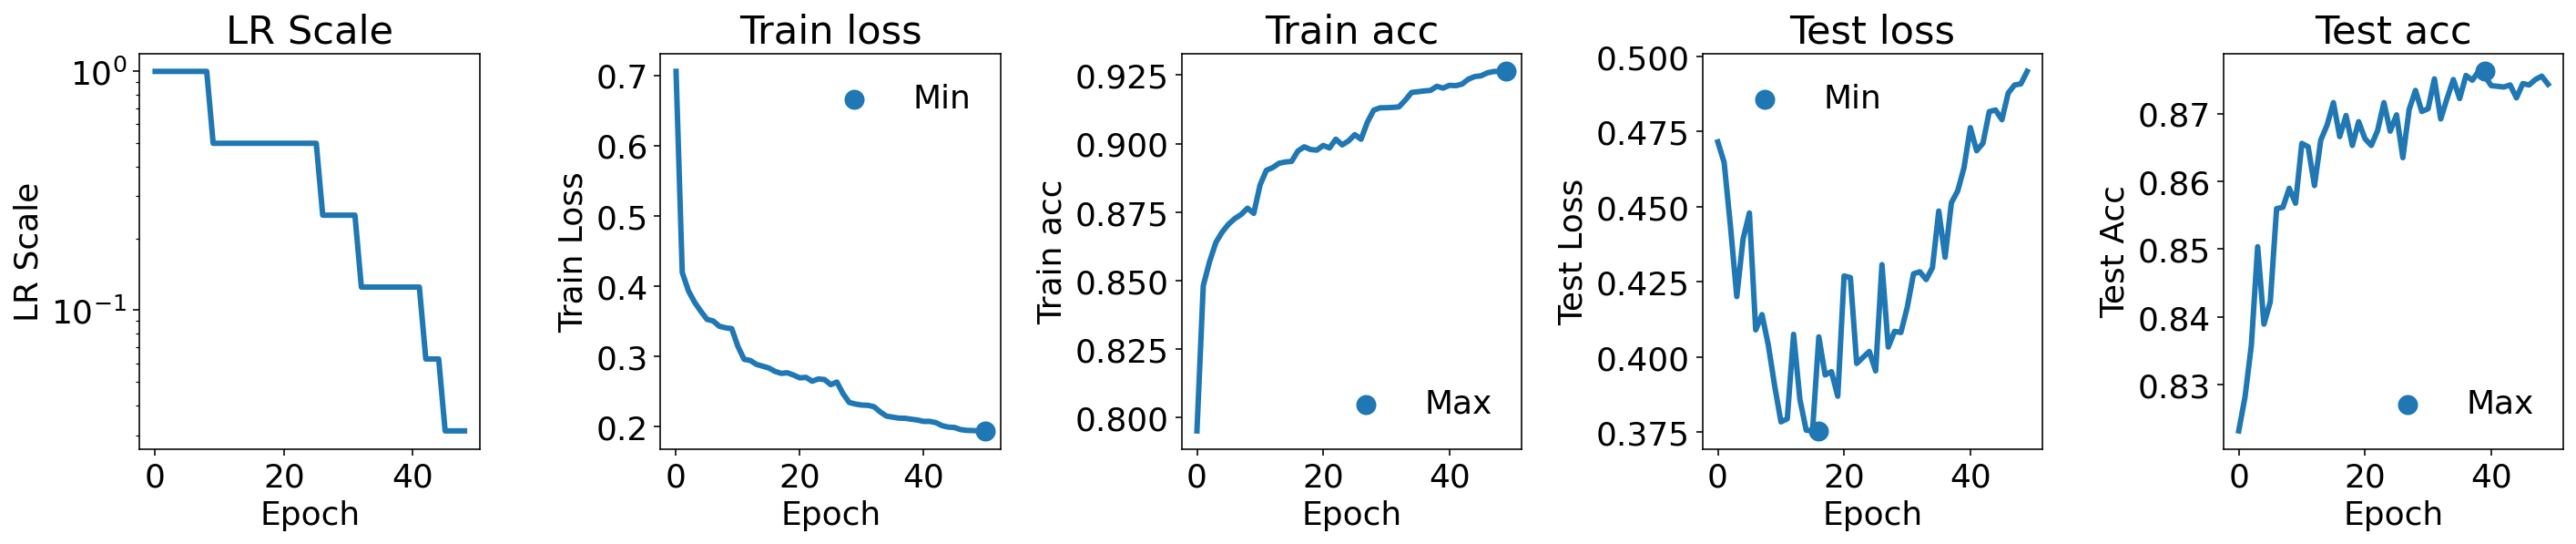

In [13]:
plot(lr_scale_history, train_losses, train_accuracy, test_losses, test_accuracy)

## Reduce on test loss plateau

Here we consider an implementation that reduces the learning rate according to the test loss value. In this example, the accumulation size is just one as we manually gather the test loss outside of the transformation.

In [14]:
# @markdown Number of epochs with no improvement after which learning rate will be reduced:
PATIENCE = 5  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 0  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 1

The base optimizer is still adam.

In [15]:
solver = optax.adam(LEARNING_RATE)
solver_state = solver.init(init_params)

In the next cell, we initialize the `contrib.reduce_on_plateau` scheduler, which reduces learning rate when a monitored metric (the test loss here) has stopped improving. We will be using this scheduler to scale the updates, produced by the regular Adam optimizer.

Note that the initial scale for the scheduler is not explicitly set, so it will default to 1.0, which means there will be no scaling of the learning rate initially.

In [16]:
transform = reduce_on_plateau(
    patience=PATIENCE,
    cooldown=COOLDOWN,
    factor=FACTOR,
    rtol=RTOL,
    accumulation_size=ACCUMULATION_SIZE
    )

# Creates initial state for `contrib.reduce_on_plateau` transformation.
transform_state = transform.init(init_params)
transform_state

ReduceLROnPlateauState(scale=Array(1., dtype=float32), best_value=Array(inf, dtype=float32), plateau_count=Array(0, dtype=int32), cooldown_count=Array(0, dtype=int32), count=Array(0, dtype=int32), avg_value=Array(0., dtype=float32))

The next cell trains the model for `N_EPOCHS` epochs. At the end of each epoch, the learning rate scaling value is updated based on the loss computed on the test set.

In [17]:
@jax.jit
def train_step(params, solver_state, transform_state, batch):
  """Performs a one step update."""
  (loss, aux), grad = jax.value_and_grad(loss_accuracy, has_aux=True)(
      params, batch
  )
  # Computes updates scaled by the learning rate that was used to initialize
  # the `solver`.
  updates, solver_state = solver.update(grad, solver_state, params)
  # Scales updates, produced by `solver`, by the scaling value.
  updates = otu.tree_scalar_mul(transform_state.scale, updates)
  params = optax.apply_updates(params, updates)
  return params, solver_state, loss, aux

params = init_params

# Computes metrics at initialization.
train_stats = dataset_stats(params, test_loader_batched)
train_accuracy = [train_stats["accuracy"]]
train_losses = [train_stats['loss']]

test_stats = dataset_stats(params, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_losses = [test_stats["loss"]]

params = init_params
lr_scale_history = [transform_state.scale]
for epoch in range(N_EPOCHS):
  train_accuracy_epoch = []
  train_losses_epoch = []

  for train_batch in train_loader_batched.as_numpy_iterator():
    params, solver_state, train_loss, train_aux = train_step(
        params, solver_state, transform_state, train_batch
    )
    train_accuracy_epoch.append(train_aux["accuracy"])
    train_losses_epoch.append(train_loss)

  mean_train_accuracy = np.mean(train_accuracy_epoch)
  mean_train_loss = np.mean(train_losses_epoch)

  # Adjusts the learning rate scaling value using the loss computed on the
  # test set.
  _, transform_state = transform.update(
      updates=params, state=transform_state, value=test_stats["loss"]
  )
  lr_scale_history.append(transform_state.scale)

  train_accuracy.append(mean_train_accuracy)
  train_losses.append(mean_train_loss)

  test_stats = dataset_stats(params, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_losses.append(test_stats["loss"])

  test_stats = dataset_stats(params, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_losses.append(test_stats["loss"])

  print(
      f"Epoch {epoch + 1}/{N_EPOCHS}, mean train accuracy:"
      f" {mean_train_accuracy}, lr scale: {transform_state.scale}"
  )

Epoch 1/50, mean train accuracy: 0.8026175498962402, lr scale: 1.0
Epoch 2/50, mean train accuracy: 0.8529981374740601, lr scale: 1.0
Epoch 3/50, mean train accuracy: 0.8595252633094788, lr scale: 1.0
Epoch 4/50, mean train accuracy: 0.8676048517227173, lr scale: 1.0
Epoch 5/50, mean train accuracy: 0.8701255321502686, lr scale: 1.0
Epoch 6/50, mean train accuracy: 0.8744324445724487, lr scale: 1.0
Epoch 7/50, mean train accuracy: 0.8766693472862244, lr scale: 1.0
Epoch 8/50, mean train accuracy: 0.8782885670661926, lr scale: 1.0
Epoch 9/50, mean train accuracy: 0.8821113705635071, lr scale: 1.0
Epoch 10/50, mean train accuracy: 0.8826956748962402, lr scale: 1.0
Epoch 11/50, mean train accuracy: 0.8834802508354187, lr scale: 1.0
Epoch 12/50, mean train accuracy: 0.8812767267227173, lr scale: 1.0
Epoch 13/50, mean train accuracy: 0.8834134340286255, lr scale: 1.0
Epoch 14/50, mean train accuracy: 0.8843482732772827, lr scale: 1.0
Epoch 15/50, mean train accuracy: 0.8863682150840759, lr 

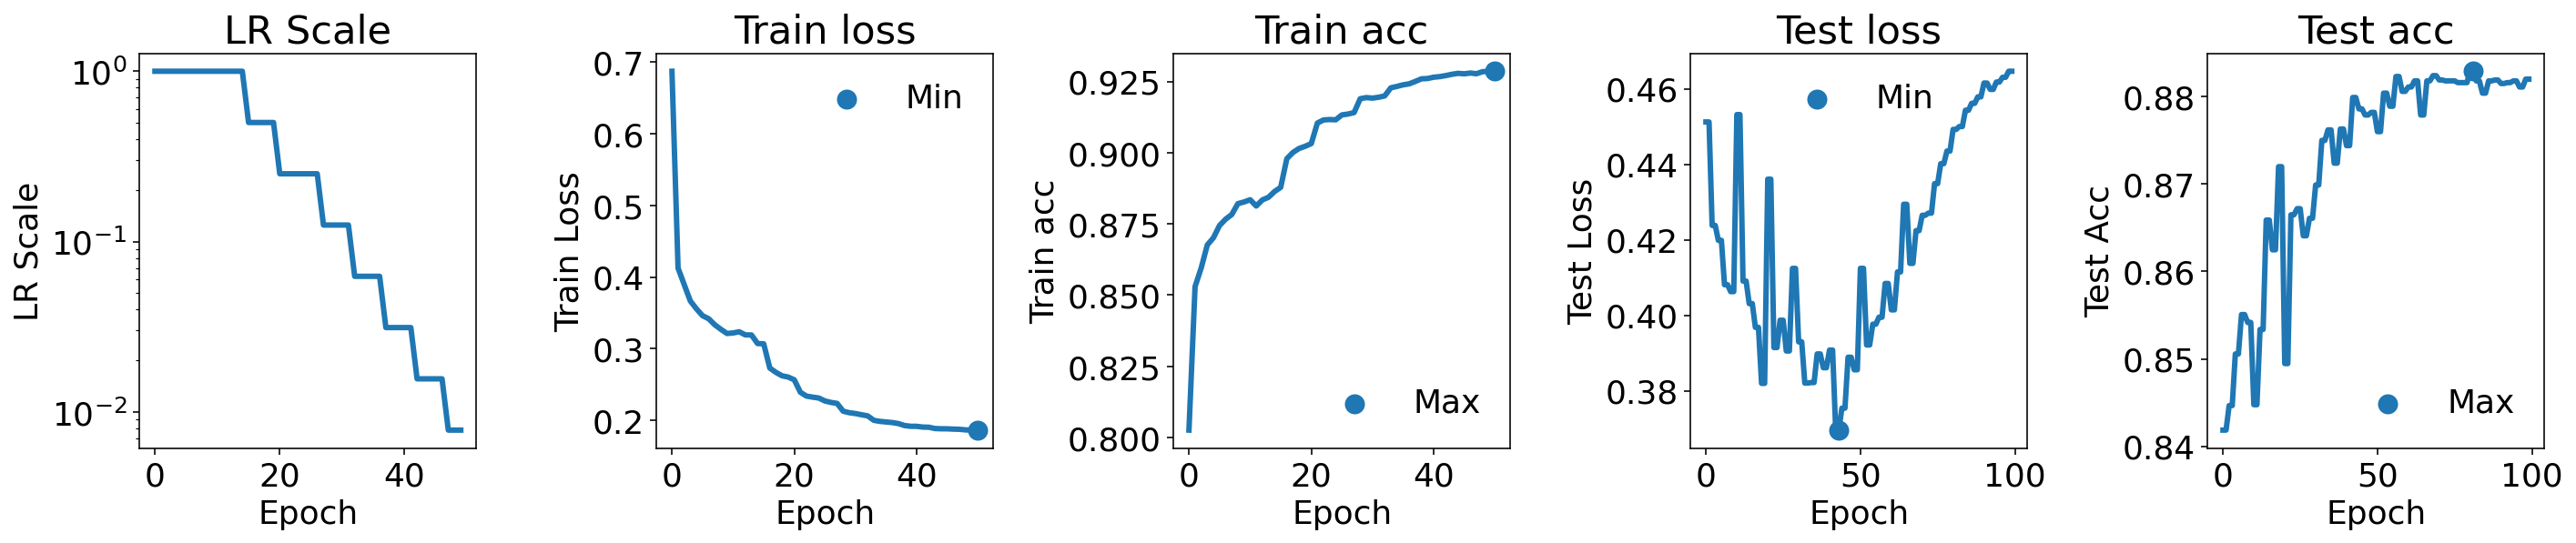

In [18]:
plot(lr_scale_history, train_losses, train_accuracy, test_losses, test_accuracy)